In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import ViTForImageClassification, AutoProcessor
from pathlib import Path
import os

import sys; sys.path.append("../src/")
from stability import soft_stability_rate
from models import MaskedImageClassifier, CertifiedMuSImageClassifier, discretized_mus_masks
from data_utils import load_images_from_directory,load_image_from_path
from explanations import \
    get_lime_for_image, get_shap_for_image, get_intgrad_for_image, get_mfaba_for_image
from visualizations import add_k_ones_enumerate, vis_masked_img, get_top_k_predictions, get_labels_containing_keyword
from visualizations import set_random_seed, MaskedImageClassifierNew, CertifiedMuSImageClassifierNew

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import math

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Load images; they will be ordered the same every time.
images = load_images_from_directory("/shared_data0/helenjin/imagenet-sample-images/")
# images = images[:20]
print(images.shape)

torch.Size([1000, 3, 224, 224])


In [3]:
# Load the model. This should be our custom fine-tuned models later!
raw_vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
# saved_data = torch.load("../_saved_models/google_vit_patch16_img224_bsz128_lr0.0001_epoch5.pt")
# raw_vit.load_state_dict(saved_data["state_dict"])
raw_vit.eval().to(device);
processor = AutoProcessor.from_pretrained('google/vit-base-patch16-224')

In [4]:
# raw_vit.load_state_dict(torch.load('/shared_data0/antonxue/google_vit_patch16_img224_bsz128_lr0.0001_epoch5.pt')['state_dict'])

In [5]:
images.min(), images.max()

(tensor(-1.), tensor(1.))

In [6]:
# torch.tensor(processor(images[0])['pixel_values']).min(), torch.tensor(processor(images[0])['pixel_values']).max()

In [7]:
import torch
from torchvision.transforms import ToPILImage

# Example tensor (C, H, W) in range [0, 1]
tensor = torch.rand(3, 256, 256)  # Example RGB image

# Convert to PIL image
to_pil = ToPILImage()
pil_image = to_pil(tensor)

# Show image
# pil_image.show()


image_proc = torch.tensor(processor(to_pil(images[0]))['pixel_values'])

In [8]:
grid_size = 4

In [9]:
wrapped_vit = MaskedImageClassifierNew(raw_vit, grid_size=(grid_size,grid_size)).to(device)
wrapped_vit.eval();
cert_mus_vit = CertifiedMuSImageClassifierNew(raw_vit, lambda_=1, 
                                              grid_size=(grid_size,grid_size),
                                             quant=64).to(device)
cert_mus_vit.eval();

In [10]:
wrapped_vit.grid_size

(4, 4)

In [11]:
def check_pred_same(wrapped_vit, cert_mus_vit, image, label, alpha=None): # label = img_idx
    wrapped_vit_pred = wrapped_vit(image.to(device), alpha).argmax(-1).item()
    cert_mus_vit_pred = cert_mus_vit(image.to(device), alpha)['logits'].argmax(-1).item()
    # print('wrapped_vit_pred', wrapped_vit_pred, 'cert_mus_vit_pred', cert_mus_vit_pred)

    if wrapped_vit_pred != cert_mus_vit_pred or wrapped_vit_pred != label or cert_mus_vit_pred != label:
        # print('cont')
        return False
    return True

# Visualize

In [12]:
# [238, 215, 282, 10, 33]

In [12]:
idx = 282
print(idx)
image = images[idx][None]
# image = image * 2 - 1
image_name = f'image_{idx}'

282


In [13]:
original_image = image

torch.Size([1, 3, 224, 224])
raw_pred tiger cat 282
smooth_pred tiger cat 282
Rank 1: Label ID = 282, Label = tiger cat, Logit = 10.0927, Probability = 0.3293
Rank 2: Label ID = 285, Label = Egyptian cat, Logit = 10.0690, Probability = 0.3216
Rank 3: Label ID = 281, Label = tabby, tabby cat, Logit = 9.9891, Probability = 0.2969
Rank 4: Label ID = 287, Label = lynx, catamount, Logit = 7.5726, Probability = 0.0265
Rank 5: Label ID = 283, Label = Persian cat, Logit = 4.5774, Probability = 0.0013
Rank 6: Label ID = 284, Label = Siamese cat, Siamese, Logit = 4.3272, Probability = 0.0010
Rank 7: Label ID = 845, Label = syringe, Logit = 3.9211, Probability = 0.0007
Rank 8: Label ID = 622, Label = lens cap, lens cover, Logit = 3.7696, Probability = 0.0006
Rank 9: Label ID = 761, Label = remote control, remote, Logit = 3.5563, Probability = 0.0005
Rank 10: Label ID = 673, Label = mouse, computer mouse, Logit = 3.4707, Probability = 0.0004


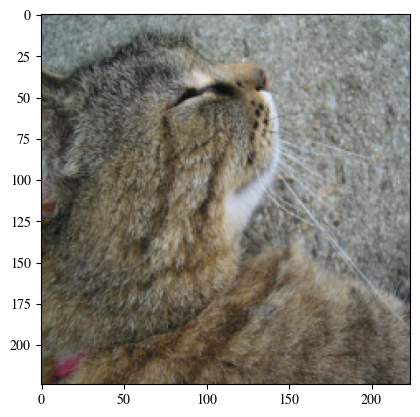

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

# plt.imshow(image[0].cpu().permute(1,2,0))
plt.imshow((image[0].cpu().permute(1,2,0) + 1) /2)
raw_pred = wrapped_vit(image.cuda()).argmax(-1).item()
set_random_seed(42)
smooth_pred = cert_mus_vit(image.cuda())['logits'].argmax(-1).item()
print(image.shape)
print('raw_pred', raw_vit.config.id2label[raw_pred], raw_pred)
print('smooth_pred', raw_vit.config.id2label[smooth_pred], smooth_pred)

# get top_k predictions
top_k = 10
top_k_preds = get_top_k_predictions(wrapped_vit, image, raw_vit, k=top_k)

# Print the top k predictions
for rank, (label_id, label_name, logit, prob) in enumerate(top_k_preds, start=1):
    print(f"Rank {rank}: Label ID = {label_id}, Label = {label_name}, Logit = {logit:.4f}, Probability = {prob:.4f}")

In [15]:
plt.imshow((image[0].cpu().permute(1,2,0) + 1) /2)
plt.axis('off')
save_path = f'_dump/useful_images/{idx}/image_{idx}.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

In [70]:
num_patches=grid_size * grid_size #49
top_k_frac = 0.4

  0%|          | 0/1000 [00:00<?, ?it/s]

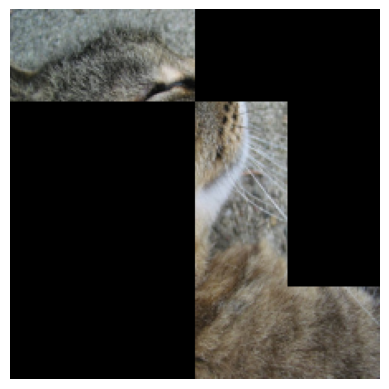

In [71]:
set_random_seed(42)
lime_expln_alpha, lime_expln, lime_expln_attrs = get_lime_for_image(wrapped_vit, 
                                                                    image[0], return_verbose=True,
                                                                   num_patches=num_patches, top_k_frac=top_k_frac)
vis_masked_img(image=image.cpu(), alpha=lime_expln_alpha.cpu(), save_path=f'_dump/useful_images/{idx}/image_{idx}_lime') 
vis_masked_img(image=image.cpu(), alpha=lime_expln_alpha.cpu()) 

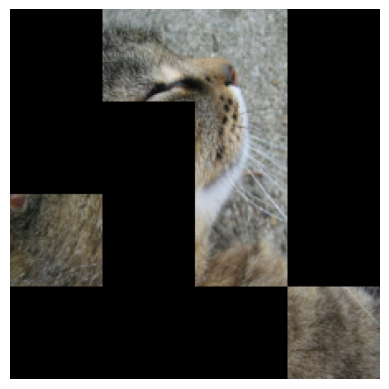

In [72]:
set_random_seed(42)
shap_expln_alpha, shap_expln, shap_expln_attrs = get_shap_for_image(wrapped_vit, 
                                                                        image[0], return_verbose=True,
                                                                       num_patches=num_patches, top_k_frac=top_k_frac)   
vis_masked_img(image=image.cpu(), alpha=shap_expln_alpha.cpu(), save_path=f'_dump/useful_images/{idx}/image_{idx}_shap') 
vis_masked_img(image=image.cpu(), alpha=shap_expln_alpha.cpu()) 

In [55]:
exp = lime_expln_alpha
r = 10
soft_stability_rate(wrapped_vit, image[0].to(device), exp.to(device), r, epsilon=0.1).item()

0.5133333206176758

In [58]:
exp = shap_expln_alpha
r = 10
soft_stability_rate(wrapped_vit, image[0].to(device), exp.to(device), r, epsilon=0.1).item()

0.7933333516120911

In [49]:
ss_list_lime = []
ss_list_shap = []

max_r = 8 

for r in range(1, max_r+1):
    ss_lime = soft_stability_rate(wrapped_vit, image[0].to(device), lime_expln_alpha.to(device), r, epsilon=0.1).item()
    ss_list_lime.append(ss_lime)
    
    ss_shap = soft_stability_rate(wrapped_vit, image[0].to(device), shap_expln_alpha.to(device), r, epsilon=0.1).item()
    ss_list_shap.append(ss_shap)
    print(ss_lime, ss_shap)

1.0 0.8799999952316284
1.0 0.8600000143051147
0.9200000166893005 0.7933333516120911
0.8266667127609253 0.846666693687439
0.8600000143051147 0.8133333325386047
0.8266667127609253 0.8199999928474426
0.8066666722297668 0.8266667127609253
0.8266667127609253 0.8533333539962769


In [62]:
ss_list_lime = []
ss_list_shap = []

max_r = 10

for r in range(1, max_r+1):
    ss_lime = soft_stability_rate(wrapped_vit, image[0].to(device), lime_expln_alpha.to(device), r, epsilon=0.1).item()
    ss_list_lime.append(ss_lime)
    
    ss_shap = soft_stability_rate(wrapped_vit, image[0].to(device), shap_expln_alpha.to(device), r, epsilon=0.1).item()
    ss_list_shap.append(ss_shap)
    print(r, ss_lime, ss_shap, abs(ss_lime - ss_shap))

1 0.5533333420753479 0.7133333683013916 0.1600000262260437
2 0.3733333349227905 0.7599999904632568 0.3866666555404663
3 0.3733333349227905 0.7066667079925537 0.3333333730697632
4 0.47333335876464844 0.7599999904632568 0.2866666316986084
5 0.48000001907348633 0.7933333516120911 0.31333333253860474
6 0.5133333206176758 0.8066666722297668 0.29333335161209106
7 0.5200000405311584 0.8066666722297668 0.2866666316986084
8 0.4533333480358124 0.7933333516120911 0.3400000035762787
9 0.5733333230018616 0.8133333325386047 0.24000000953674316
10 0.5066666603088379 0.7800000309944153 0.2733333706855774


In [69]:
ss_list_lime = []
ss_list_shap = []

max_r = 11

for r in range(1, max_r+1):
    ss_lime = soft_stability_rate(wrapped_vit, image[0].to(device), lime_expln_alpha.to(device), r, epsilon=0.1).item()
    ss_list_lime.append(ss_lime)
    
    ss_shap = soft_stability_rate(wrapped_vit, image[0].to(device), shap_expln_alpha.to(device), r, epsilon=0.1).item()
    ss_list_shap.append(ss_shap)
    print(r, ss_lime, ss_shap, abs(ss_lime - ss_shap))

1 0.7866666913032532 0.4266666769981384 0.36000001430511475
2 0.699999988079071 0.4266666769981384 0.2733333110809326
3 0.6200000047683716 0.4399999976158142 0.18000000715255737
4 0.5866667032241821 0.3733333349227905 0.2133333683013916
5 0.5666666626930237 0.24000000953674316 0.3266666531562805
6 0.6066666841506958 0.25333333015441895 0.35333335399627686
7 0.6333333253860474 0.2266666740179062 0.4066666513681412
8 0.6866666674613953 0.25333333015441895 0.4333333373069763
9 0.6000000238418579 0.24666666984558105 0.35333335399627686
10 0.6333333253860474 0.2866666615009308 0.3466666638851166
11 0.6866666674613953 0.3333333432674408 0.35333332419395447


In [ ]:
info_dict = {
    'idx': idx,
    'expln': 'lime',
    'soft stability': ss_list,
    'hs_stability': hs_radius,
    'smooth_pred_name': raw_vit.config.id2label[smooth_pred],
    'smooth_pred': smooth_pred,
    'params': {'epsilon': 0.01, 'grid_size': 4, 'top_k_frac': 0.5, 'lambda_': 1, 'quant': 64, 'model': 'base'}
}

torch.save(info_dict, f'_dump/useful_images/{idx}/info_dict_lime.pt')

In [ ]:
info_dict = {
    'idx': idx,
    'expln': 'shap',
    'soft stability': ss_list,
    'hs_stability': hs_radius,
    'smooth_pred_name': raw_vit.config.id2label[smooth_pred],
    'smooth_pred': smooth_pred,
    'params': {'epsilon': 0.01, 'grid_size': 4, 'top_k_frac': 0.5, 'lambda_': 1, 'quant': 64, 'model': 'base'}
}

torch.save(info_dict, f'_dump/useful_images/{idx}/info_dict_shap.pt')

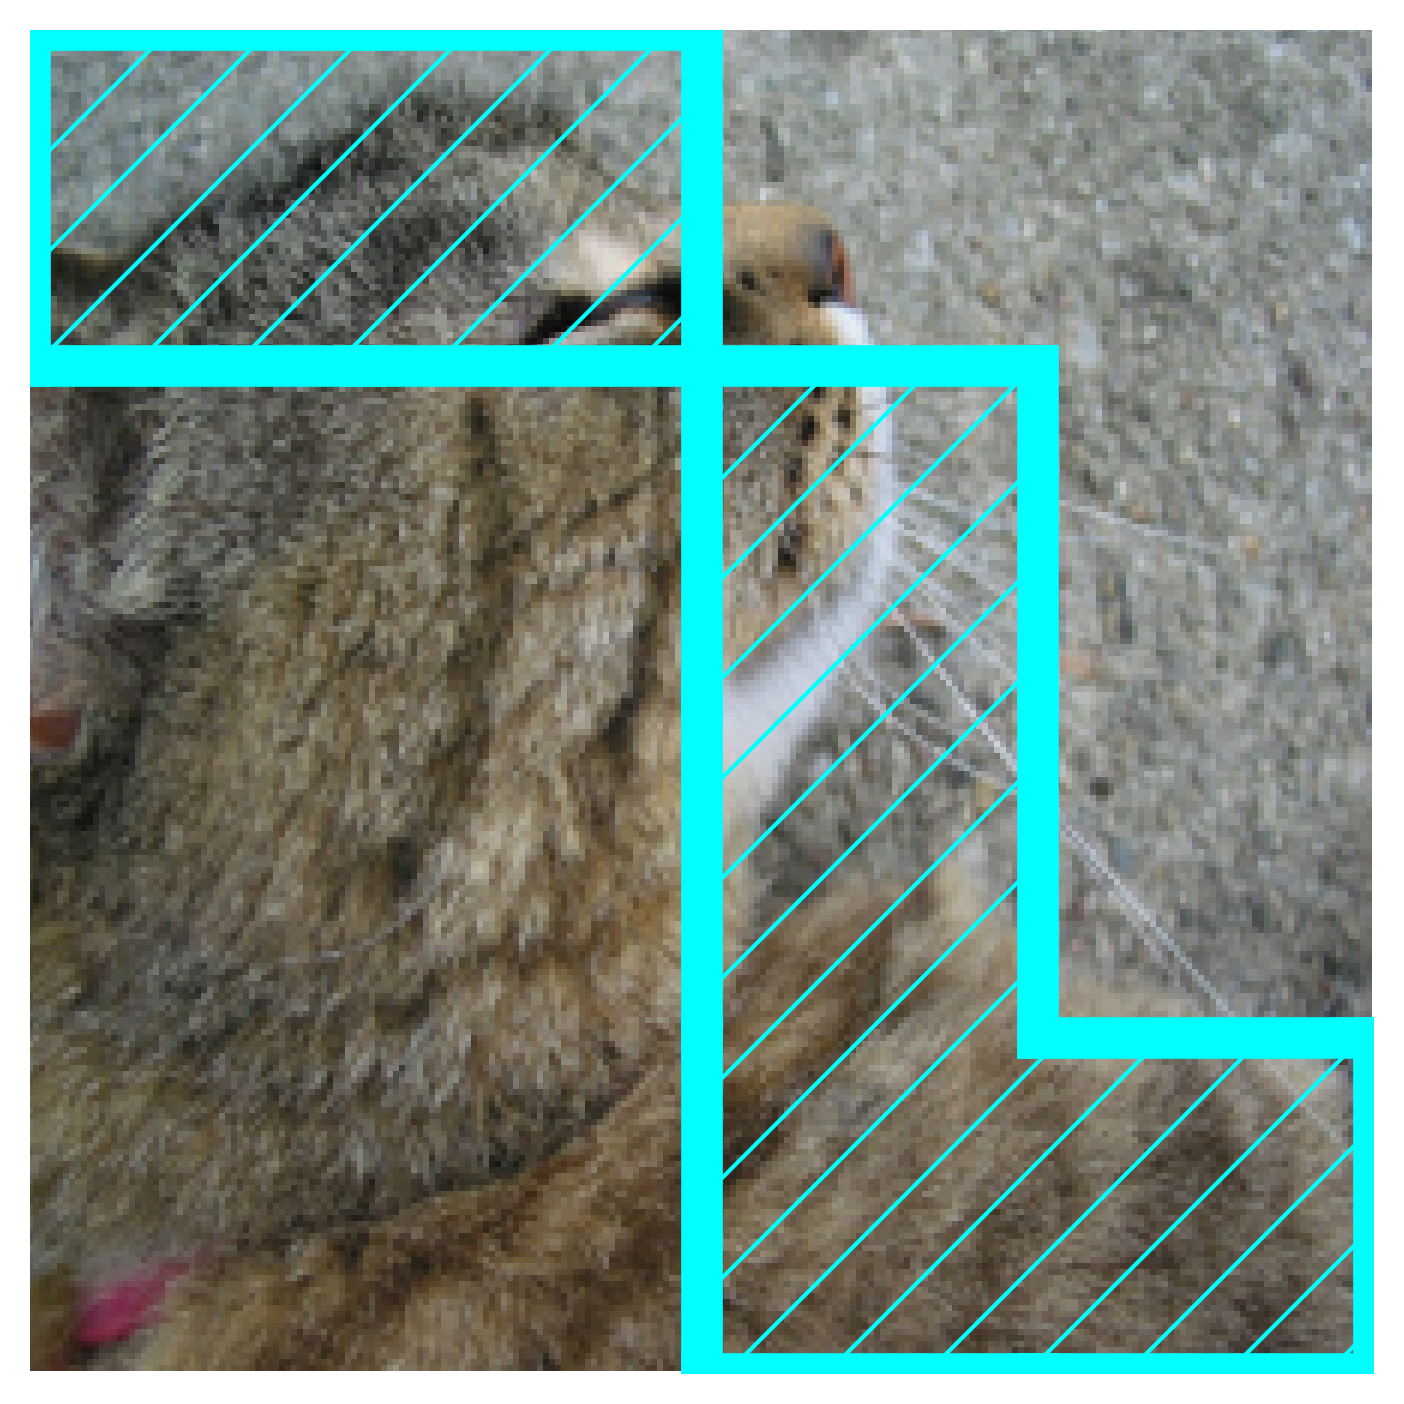

In [85]:
i = 0
image = 0.5 * (1 + original_image) 
img = image[0]
imgi = 0
HIGH_DPI = 300  # Increase for better quality
SCALE_FACTOR = 2  # Adjust to make figure larger
mask = lime_expln_alpha.cpu().squeeze()
color = 'aqua'
linewidth = 10
hatch = '/'
img_h, img_w = img.shape[1], img.shape[2]
patch_size = img_h / grid_size 

fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
ax.imshow(img.numpy().transpose(1, 2, 0))
ax.set_xlim(0, img_w)
ax.set_ylim(img_h, 0)
ax.set_position([0, 0, 1, 1])
ax.axis('off')
for i, j in zip(*np.where(mask == 1)):
    left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
    top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
    if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
    if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
for i, j in zip(*np.where(mask == 1)):
    ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
fig.canvas.draw()
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime_all.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)

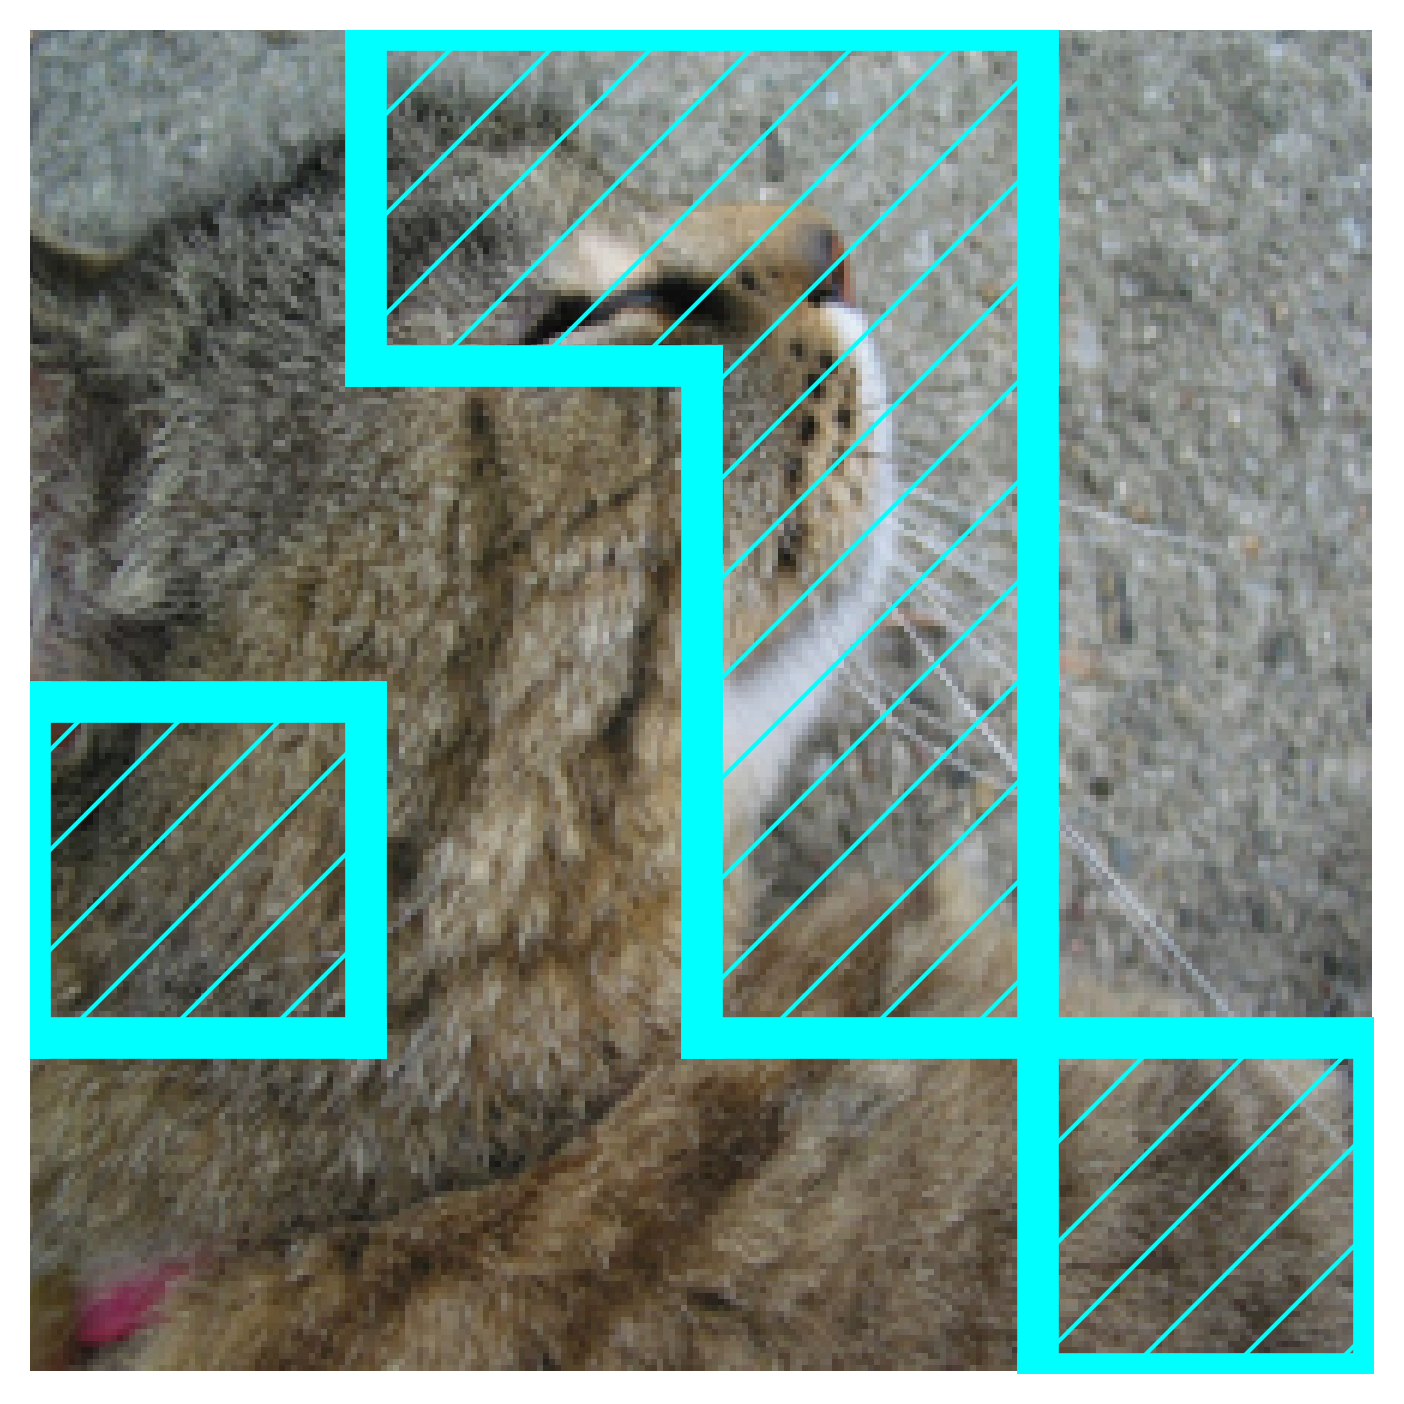

In [87]:
i = 0
image = 0.5 * (1 + original_image) 
img = image[0]
imgi = 0
HIGH_DPI = 300  # Increase for better quality
SCALE_FACTOR = 2  # Adjust to make figure larger
mask = shap_expln_alpha.cpu().squeeze()
color = 'aqua'
linewidth = 10
hatch = '/'
img_h, img_w = img.shape[1], img.shape[2]
patch_size = img_h / grid_size 

fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
ax.imshow(img.numpy().transpose(1, 2, 0))
ax.set_xlim(0, img_w)
ax.set_ylim(img_h, 0)
ax.set_position([0, 0, 1, 1])
ax.axis('off')
for i, j in zip(*np.where(mask == 1)):
    left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
    top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
    if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
    if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
for i, j in zip(*np.where(mask == 1)):
    ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
fig.canvas.draw()
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_shap_all.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)

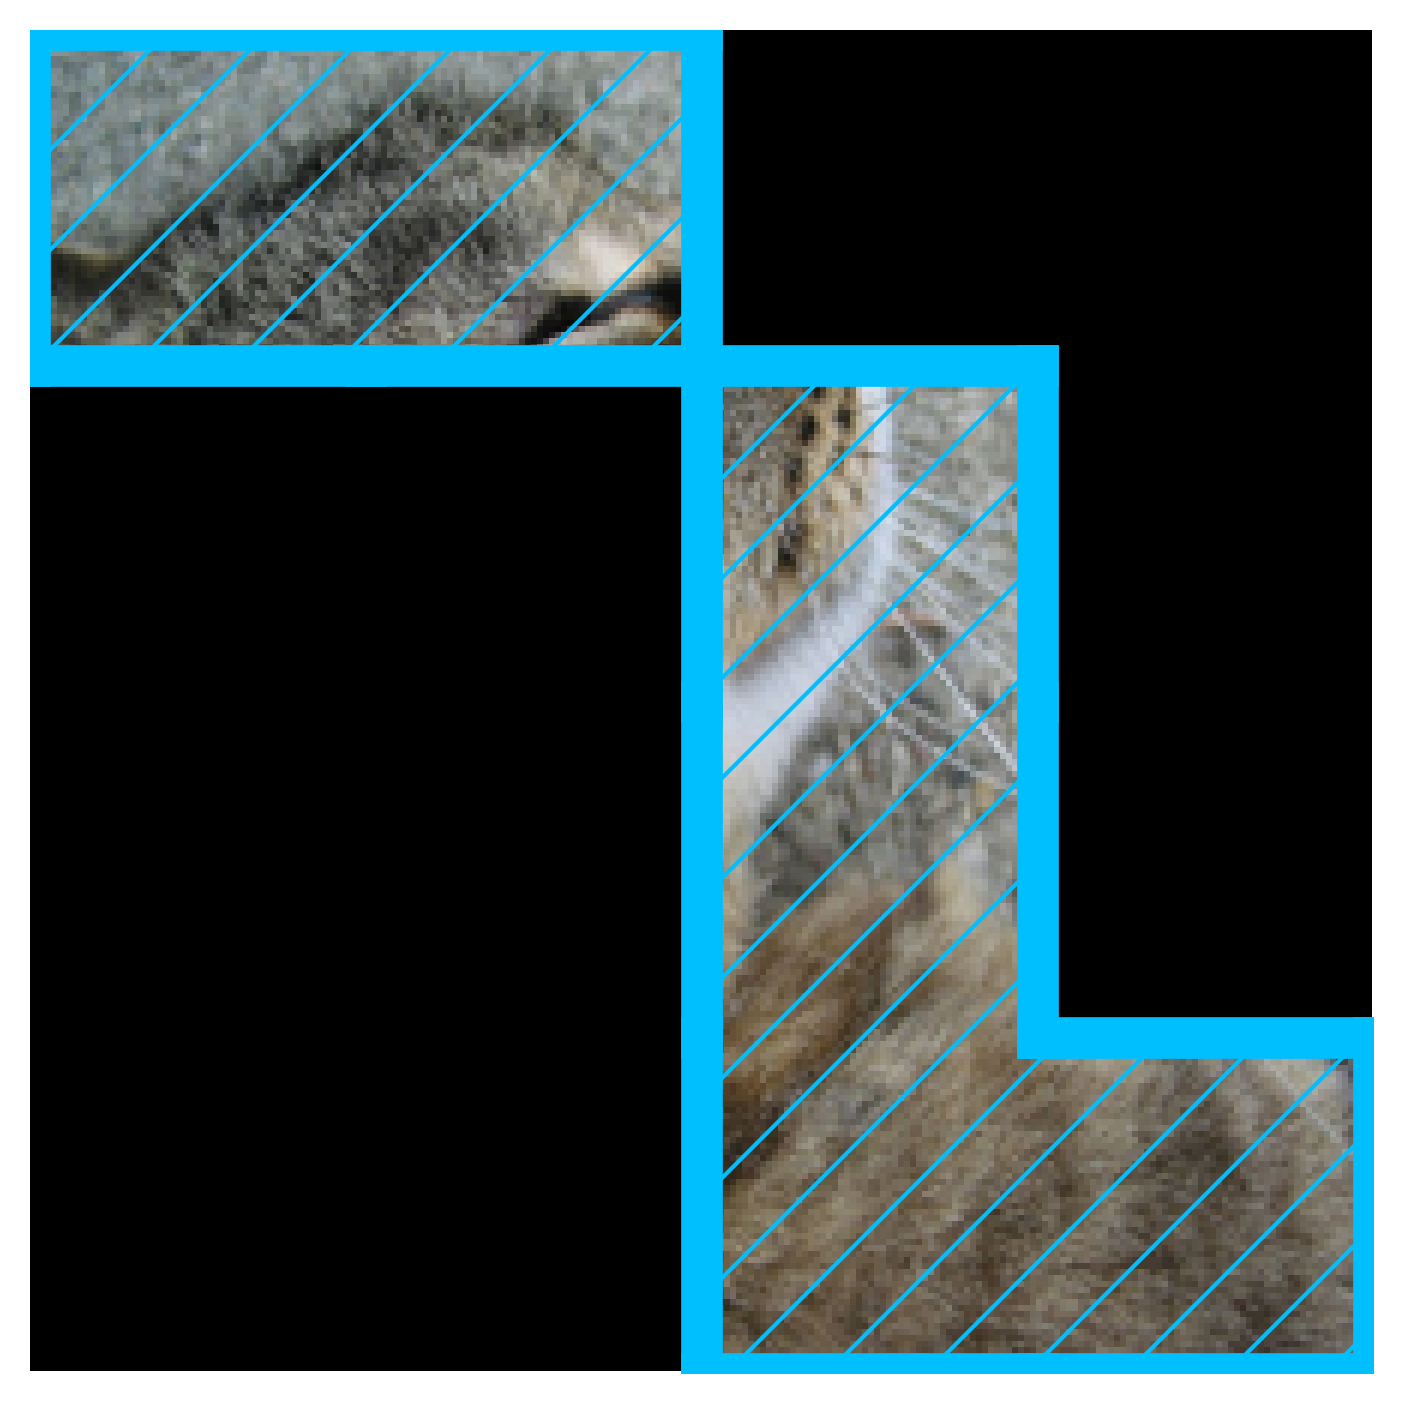

In [93]:
i = 0
image = 0.5 * (1 + original_image) * F.interpolate(lime_expln_alpha.cpu().unsqueeze(1).float(), size=(224,224))
img = image[0]
imgi = 0
HIGH_DPI = 300  # Increase for better quality
SCALE_FACTOR = 2  # Adjust to make figure larger
mask = lime_expln_alpha.cpu().squeeze()
color = 'deepskyblue'
linewidth = 10
hatch = '/'
img_h, img_w = img.shape[1], img.shape[2]
patch_size = img_h / grid_size 

fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
ax.imshow(img.numpy().transpose(1, 2, 0))
ax.set_xlim(0, img_w)
ax.set_ylim(img_h, 0)
ax.set_position([0, 0, 1, 1])
ax.axis('off')
for i, j in zip(*np.where(mask == 1)):
    left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
    top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
    if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
    if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
for i, j in zip(*np.where(mask == 1)):
    ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
fig.canvas.draw()
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)

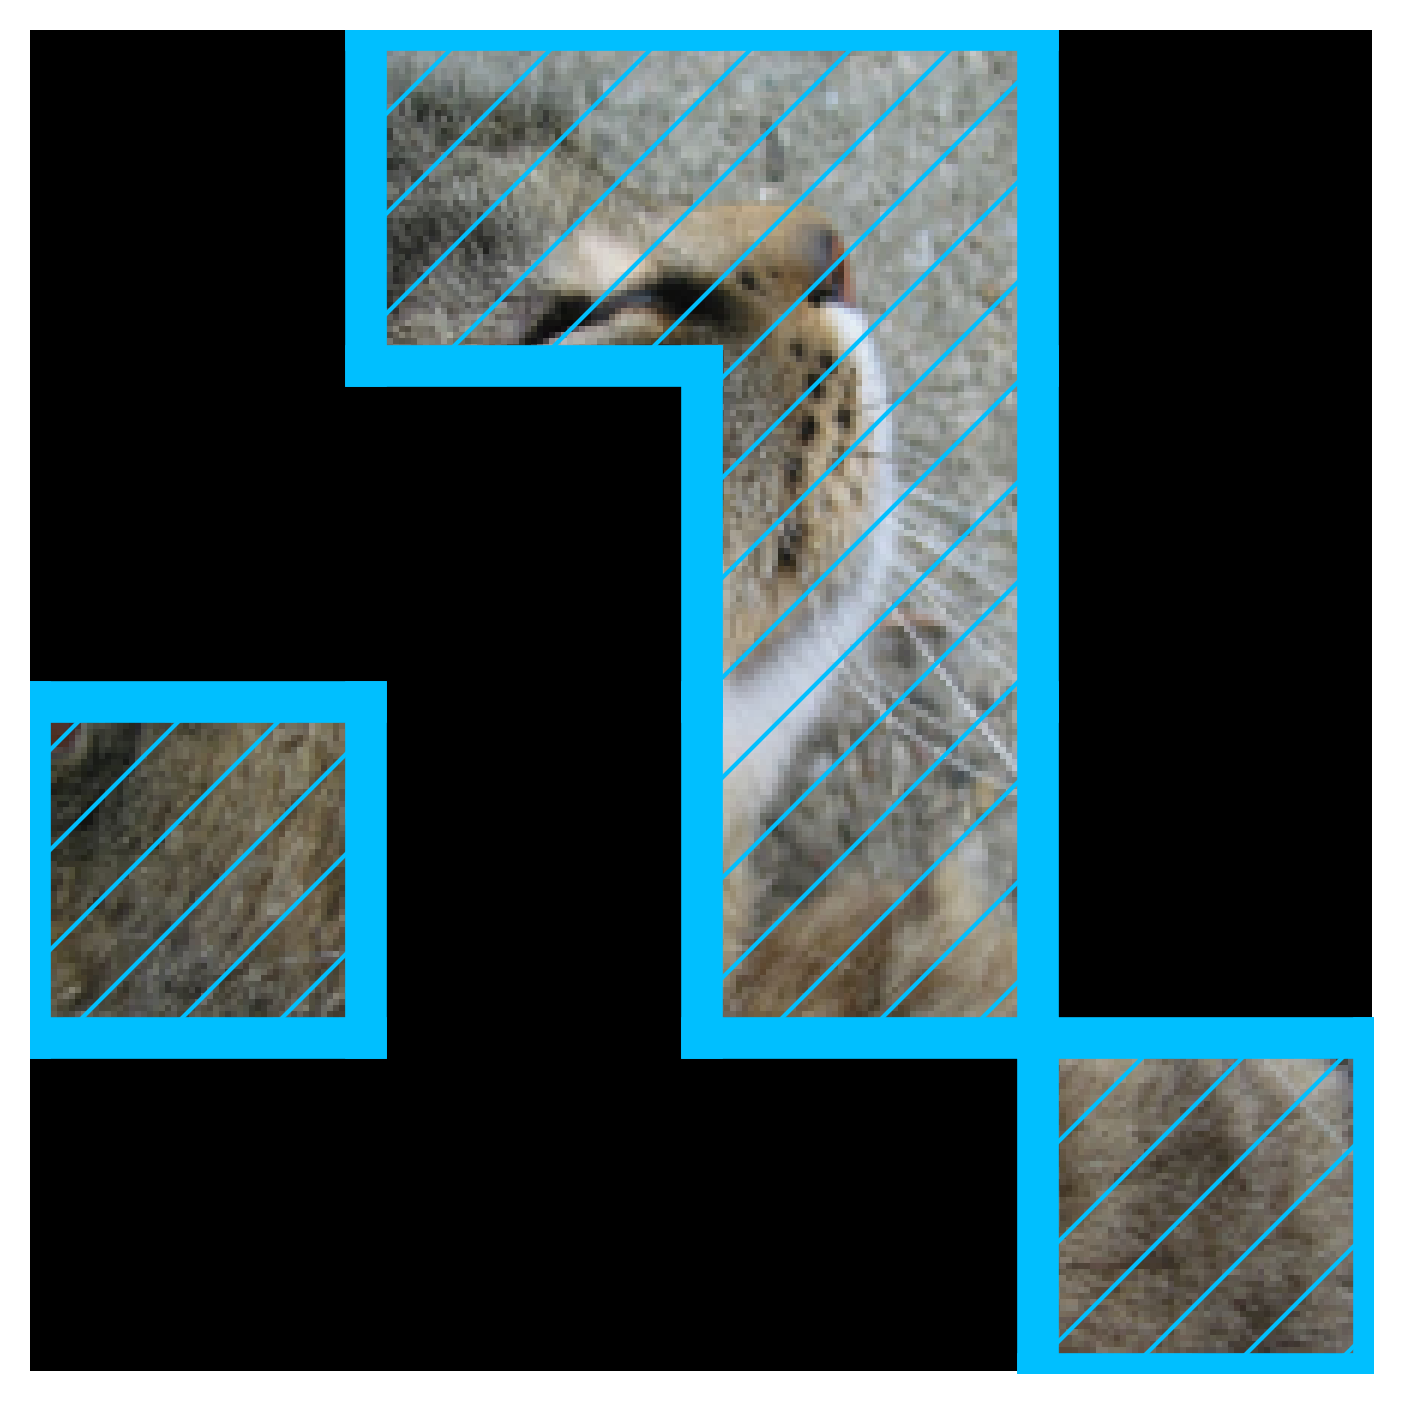

In [94]:
i = 0
image = 0.5 * (1 + original_image) * F.interpolate(shap_expln_alpha.cpu().unsqueeze(1).float(), size=(224,224))
img = image[0]
imgi = 0
HIGH_DPI = 300  # Increase for better quality
SCALE_FACTOR = 2  # Adjust to make figure larger
mask = shap_expln_alpha.cpu().squeeze()
# color = 'pink'
linewidth = 10
hatch = '/'
img_h, img_w = img.shape[1], img.shape[2]
patch_size = img_h / grid_size 

fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
ax.imshow(img.numpy().transpose(1, 2, 0))
ax.set_xlim(0, img_w)
ax.set_ylim(img_h, 0)
ax.set_position([0, 0, 1, 1])
ax.axis('off')
for i, j in zip(*np.where(mask == 1)):
    left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
    top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
    if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
    if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
for i, j in zip(*np.where(mask == 1)):
    ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
fig.canvas.draw()
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_shap.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)

In [21]:
r = 8
ss_dict = soft_stability_rate(wrapped_vit, image[0].to(device), exp.to(device), r, epsilon=0.01, return_all=True)


In [22]:
torch.save(ss_dict, f'_dump/useful_images/{idx}/ss_dict.pt')

In [23]:
ss_dict['y_pertbs'].shape

torch.Size([14979, 1000])

In [24]:
ss_dict['matches'].float().mean()

tensor(0.8137, device='cuda:0')

In [25]:
good_alphas = ss_dict["alpha_pertbs"][ss_dict["matches"]].cpu()
bad_alphas = ss_dict["alpha_pertbs"][~ss_dict["matches"]].cpu()

In [26]:
(torch.unique(good_alphas[good_alphas.sum(dim=(1,2,3)) == 9], dim=0)).shape

torch.Size([8, 1, 4, 4])

In [27]:
# Some representative good alphas
good_alphas_r1 = torch.unique(good_alphas[good_alphas.sum(dim=(1,2,3)) == 9], dim=0)[:10]
good_alphas_r2 = torch.unique(good_alphas[good_alphas.sum(dim=(1,2,3)) == 10], dim=0)[:10]
good_alphas_r3 = torch.unique(good_alphas[good_alphas.sum(dim=(1,2,3)) == 11], dim=0)[:10]
good_alphas_r4 = torch.unique(good_alphas[good_alphas.sum(dim=(1,2,3)) == 12], dim=0)[:10]
good_alphas_r5 = torch.unique(good_alphas[good_alphas.sum(dim=(1,2,3)) == 13], dim=0)[:10]
good_alphas_r6 = torch.unique(good_alphas[good_alphas.sum(dim=(1,2,3)) == 14], dim=0)[:10]
good_alphas_r7 = torch.unique(good_alphas[good_alphas.sum(dim=(1,2,3)) == 15], dim=0)[:10]


In [28]:
# torch.save(good_alphas_r1, f'image_{idx}_good_alphas_r1.pt')
# torch.save(good_alphas_r2, f'image_{idx}_good_alphas_r2.pt')
# torch.save(good_alphas_r3, f'image_{idx}_good_alphas_r3.pt')
# torch.save(good_alphas_r4, f'image_{idx}_good_alphas_r4.pt')
# torch.save(good_alphas_r5, f'image_{idx}_good_alphas_r5.pt')
torch.save(good_alphas_r6, f'image_{idx}_good_alphas_r6.pt')
torch.save(good_alphas_r7, f'image_{idx}_good_alphas_r7.pt')


In [29]:
good_alphas_r2.shape

torch.Size([10, 1, 4, 4])

In [30]:
# image_good_r1s = 0.5 * (1 + image) * F.interpolate(good_alphas_r1.float(), size=(224,224))
# image_good_r2s = 0.5 * (1 + image) * F.interpolate(good_alphas_r2.float(), size=(224,224))
# image_good_r3s = 0.5 * (1 + image) * F.interpolate(good_alphas_r3.float(), size=(224,224))
# image_good_r4s = 0.5 * (1 + image) * F.interpolate(good_alphas_r4.float(), size=(224,224))
# image_good_r5s = 0.5 * (1 + image) * F.interpolate(good_alphas_r5.float(), size=(224,224))
image_good_r6s = 0.5 * (1 + image) * F.interpolate(good_alphas_r6.float(), size=(224,224))
image_good_r7s = 0.5 * (1 + image) * F.interpolate(good_alphas_r7.float(), size=(224,224))


In [31]:
# torch.save(image_good_r1s, f'image_{idx}_image_good_r1s.pt')
# torch.save(image_good_r2s, f'image_{idx}_image_good_r2s.pt')
# torch.save(image_good_r3s, f'image_{idx}_image_good_r3s.pt')
# torch.save(image_good_r4s, f'image_{idx}_image_good_r4s.pt')
# torch.save(image_good_r5s, f'image_{idx}_image_good_r5s.pt')
torch.save(image_good_r6s, f'image_{idx}_image_good_r6s.pt')
torch.save(image_good_r7s, f'image_{idx}_image_good_r7s.pt')

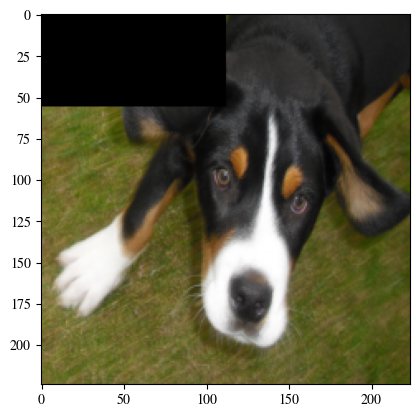

In [33]:
plt.clf()
plt.imshow(image_good_r6s[0].numpy().transpose(1,2,0))

In [34]:
# Save everything
# for i, img in enumerate(image_good_r1s):
#     plt.clf()
#     plt.imshow(img.numpy().transpose(1,2,0))
#     plt.axis('off')
#     save_path = f'_dump/useful_images/{idx}/image_{idx}_lime_good_alpha_r1_{i}'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
#     plt.close()
    
# for i, img in enumerate(image_good_r2s):
#     plt.clf()
#     plt.imshow(img.numpy().transpose(1,2,0))
#     plt.axis('off')
#     save_path = f'_dump/useful_images/{idx}/image_{idx}_lime_good_alpha_r2_{i}'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
#     plt.close()

# for i, img in enumerate(image_good_r3s):
#     plt.clf()
#     plt.imshow(img.numpy().transpose(1,2,0))
#     plt.axis('off')
#     save_path = f'_dump/useful_images/{idx}/image_{idx}_lime_good_alpha_r3_{i}'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
#     plt.close()
    
# for i, img in enumerate(image_good_r4s):
#     plt.clf()
#     plt.imshow(img.numpy().transpose(1,2,0))
#     plt.axis('off')
#     save_path = f'_dump/useful_images/{idx}/image_{idx}_lime_good_alpha_r4_{i}'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
#     plt.close()

# for i, img in enumerate(image_good_r5s):
#     plt.clf()
#     plt.imshow(img.numpy().transpose(1,2,0))
#     plt.axis('off')
#     save_path = f'_dump/useful_images/{idx}/image_{idx}_lime_good_alpha_r5_{i}'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
#     plt.close()

for i, img in enumerate(image_good_r6s):
    plt.clf()
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    save_path = f'_dump/useful_images/{idx}/image_{idx}_lime_good_alpha_r6_{i}'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

for i, img in enumerate(image_good_r7s):
    plt.clf()
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    save_path = f'_dump/useful_images/{idx}/image_{idx}_lime_good_alpha_r7_{i}'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

In [35]:
# Sanity check
bad_alphas_r1 = bad_alphas[bad_alphas.sum(dim=(1,2,3)) == 9]
bad_alphas_r2 = bad_alphas[bad_alphas.sum(dim=(1,2,3)) == 10]
print(bad_alphas_r1.shape, bad_alphas_r2.shape)

torch.Size([0, 1, 4, 4]) torch.Size([0, 1, 4, 4])


In [36]:
# Representative bad_alphas of some sizes
# bad_alphas_r3 = torch.unique(bad_alphas[bad_alphas.sum(dim=(1,2,3)) == 11], dim=0)[:10]
# bad_alphas_r4 = torch.unique(bad_alphas[bad_alphas.sum(dim=(1,2,3)) == 12], dim=0)[:10]
# bad_alphas_r5 = torch.unique(bad_alphas[bad_alphas.sum(dim=(1,2,3)) == 13], dim=0)[:10]
bad_alphas_r6 = torch.unique(bad_alphas[bad_alphas.sum(dim=(1,2,3)) == 14], dim=0)[:10]
bad_alphas_r7 = torch.unique(bad_alphas[bad_alphas.sum(dim=(1,2,3)) == 15], dim=0)[:10]


# bad_alpha_r3 = bad_alphas_r3[0]
# bad_alpha_r4_1 = bad_alphas_r4[0]
# bad_alpha_r4_2 = bad_alphas_r4[1]
# bad_alpha_r5 = bad_alphas_r5[0]

In [37]:
# torch.save(bad_alphas_r3, f'image_{idx}_bad_alphas_r3.pt')
# torch.save(bad_alphas_r4, f'image_{idx}_bad_alphas_r4.pt')
# torch.save(bad_alphas_r5, f'image_{idx}_bad_alphas_r5.pt')
torch.save(bad_alphas_r6, f'image_{idx}_bad_alphas_r5.pt')
torch.save(bad_alphas_r7, f'image_{idx}_bad_alphas_r5.pt')


In [38]:
# image_bad_r3s = 0.5 * (1 + image) * F.interpolate(bad_alphas_r3.float(), size=(224,224))
# image_bad_r4s = 0.5 * (1 + image) * F.interpolate(bad_alphas_r4.float(), size=(224,224))
# image_bad_r5s = 0.5 * (1 + image) * F.interpolate(bad_alphas_r5.float(), size=(224,224))
image_bad_r6s = 0.5 * (1 + image) * F.interpolate(bad_alphas_r6.float(), size=(224,224))
image_bad_r7s = 0.5 * (1 + image) * F.interpolate(bad_alphas_r7.float(), size=(224,224))

In [40]:
# torch.save(image_bad_r3s, f'image_{idx}_image_bad_r3s.pt')
# torch.save(image_bad_r4s, f'image_{idx}_image_bad_r4s.pt')
# torch.save(image_bad_r5s, f'image_{idx}_image_bad_r5s.pt')
torch.save(image_bad_r6s, f'image_{idx}_image_bad_r6s.pt')
torch.save(image_bad_r7s, f'image_{idx}_image_bad_r7s.pt')


In [41]:
# Save everything
# for i, img in enumerate(image_bad_r3s):
#     plt.clf()
#     plt.imshow(img.numpy().transpose(1,2,0))
#     plt.axis('off')
#     save_path = f'_dump/useful_images/{idx}/image_{idx}_lime_bad_alpha_r3_{i}'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
#     plt.close()
    
# for i, img in enumerate(image_bad_r4s):
#     plt.clf()
#     plt.imshow(img.numpy().transpose(1,2,0))
#     plt.axis('off')
#     save_path = f'_dump/useful_images/{idx}/image_{idx}_lime_bad_alpha_r4_{i}'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
#     plt.close()

# for i, img in enumerate(image_bad_r5s):
#     plt.clf()
#     plt.imshow(img.numpy().transpose(1,2,0))
#     plt.axis('off')
#     save_path = f'_dump/useful_images/{idx}/image_{idx}_lime_bad_alpha_r5_{i}'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
#     plt.close()

for i, img in enumerate(image_bad_r6s):
    plt.clf()
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    save_path = f'_dump/useful_images/{idx}/image_{idx}_lime_bad_alpha_r6_{i}'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

for i, img in enumerate(image_bad_r7s):
    plt.clf()
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    save_path = f'_dump/useful_images/{idx}/image_{idx}_lime_bad_alpha_r7_{i}'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()


In [42]:
bad_alphas_r3 = bad_alphas[bad_alphas.sum(dim=(1,2,3)) == 11]
bad_alphas_r3.shape

torch.Size([409, 1, 4, 4])

In [43]:
bad_alphas_r4 = bad_alphas[bad_alphas.sum(dim=(1,2,3)) == 12]
bad_alphas_r4.shape

torch.Size([882, 1, 4, 4])

In [44]:
bad_alphas_r5 = bad_alphas[bad_alphas.sum(dim=(1,2,3)) == 13]
bad_alphas_r5.shape

torch.Size([849, 1, 4, 4])

## load images + do more

In [45]:
idx = 238
i = 0
load_image_path = f'_dump/useful_images/{idx}/image_{idx}_lime.png'
load_image = load_image_from_path(load_image_path)
lime_image = 0.5 * (1 + load_image) * F.interpolate(lime_expln_alpha.cpu().unsqueeze(1).float(), size=(224,224))
lime_image = lime_image[0]

In [46]:
lime_expln_alpha.shape

torch.Size([1, 4, 4])

In [47]:
bad_alphas_r3.shape

torch.Size([409, 1, 4, 4])

In [49]:
lime_image.shape

torch.Size([3, 224, 224])

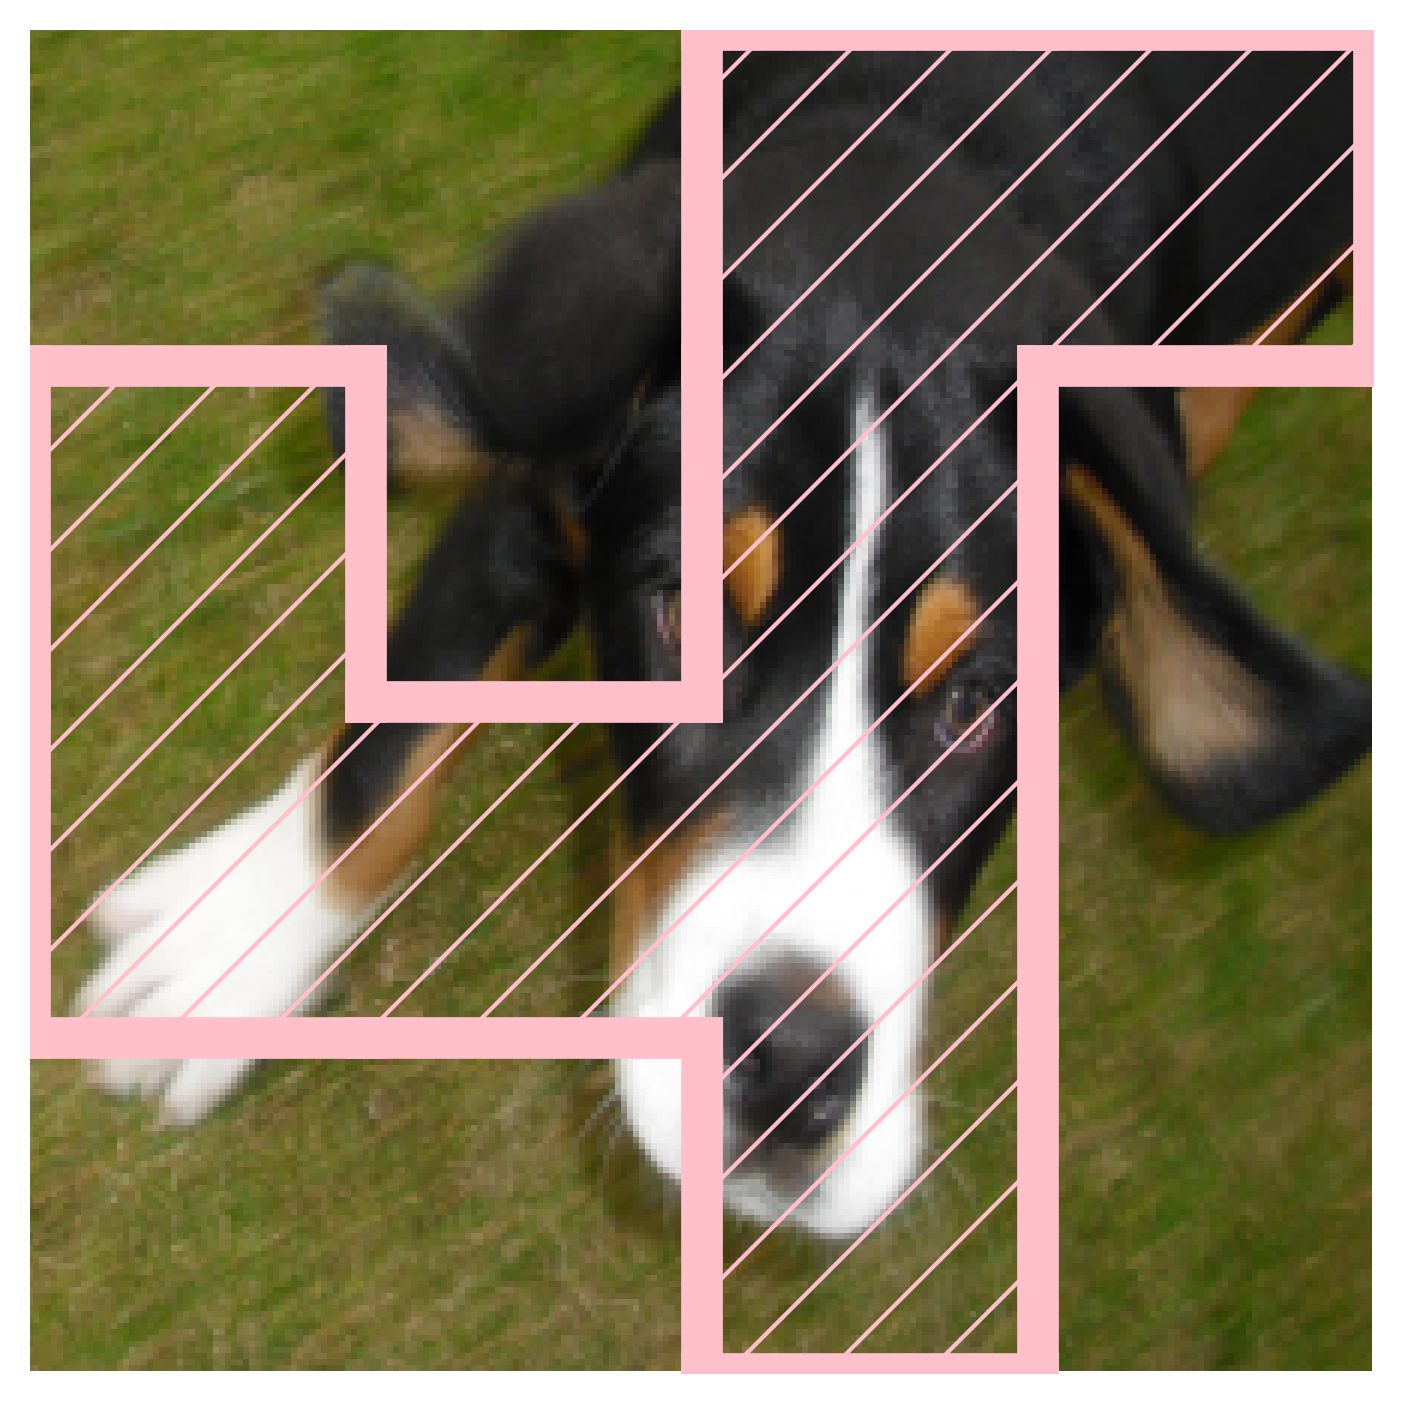

In [72]:
idx = 238
i = 0
image = 0.5 * (1 + original_image) 
img = image[0]
imgi = 0
HIGH_DPI = 300  # Increase for better quality
SCALE_FACTOR = 2  # Adjust to make figure larger
mask = lime_expln_alpha.cpu().squeeze()
color = 'pink'
linewidth = 10
hatch = '/'
img_h, img_w = img.shape[1], img.shape[2]
patch_size = img_h / grid_size 

fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
ax.imshow(img.numpy().transpose(1, 2, 0))
ax.set_xlim(0, img_w)
ax.set_ylim(img_h, 0)
ax.set_position([0, 0, 1, 1])
ax.axis('off')
for i, j in zip(*np.where(mask == 1)):
    left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
    top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
    if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
    if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
for i, j in zip(*np.where(mask == 1)):
    ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
fig.canvas.draw()
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime_good_alpha_r8.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


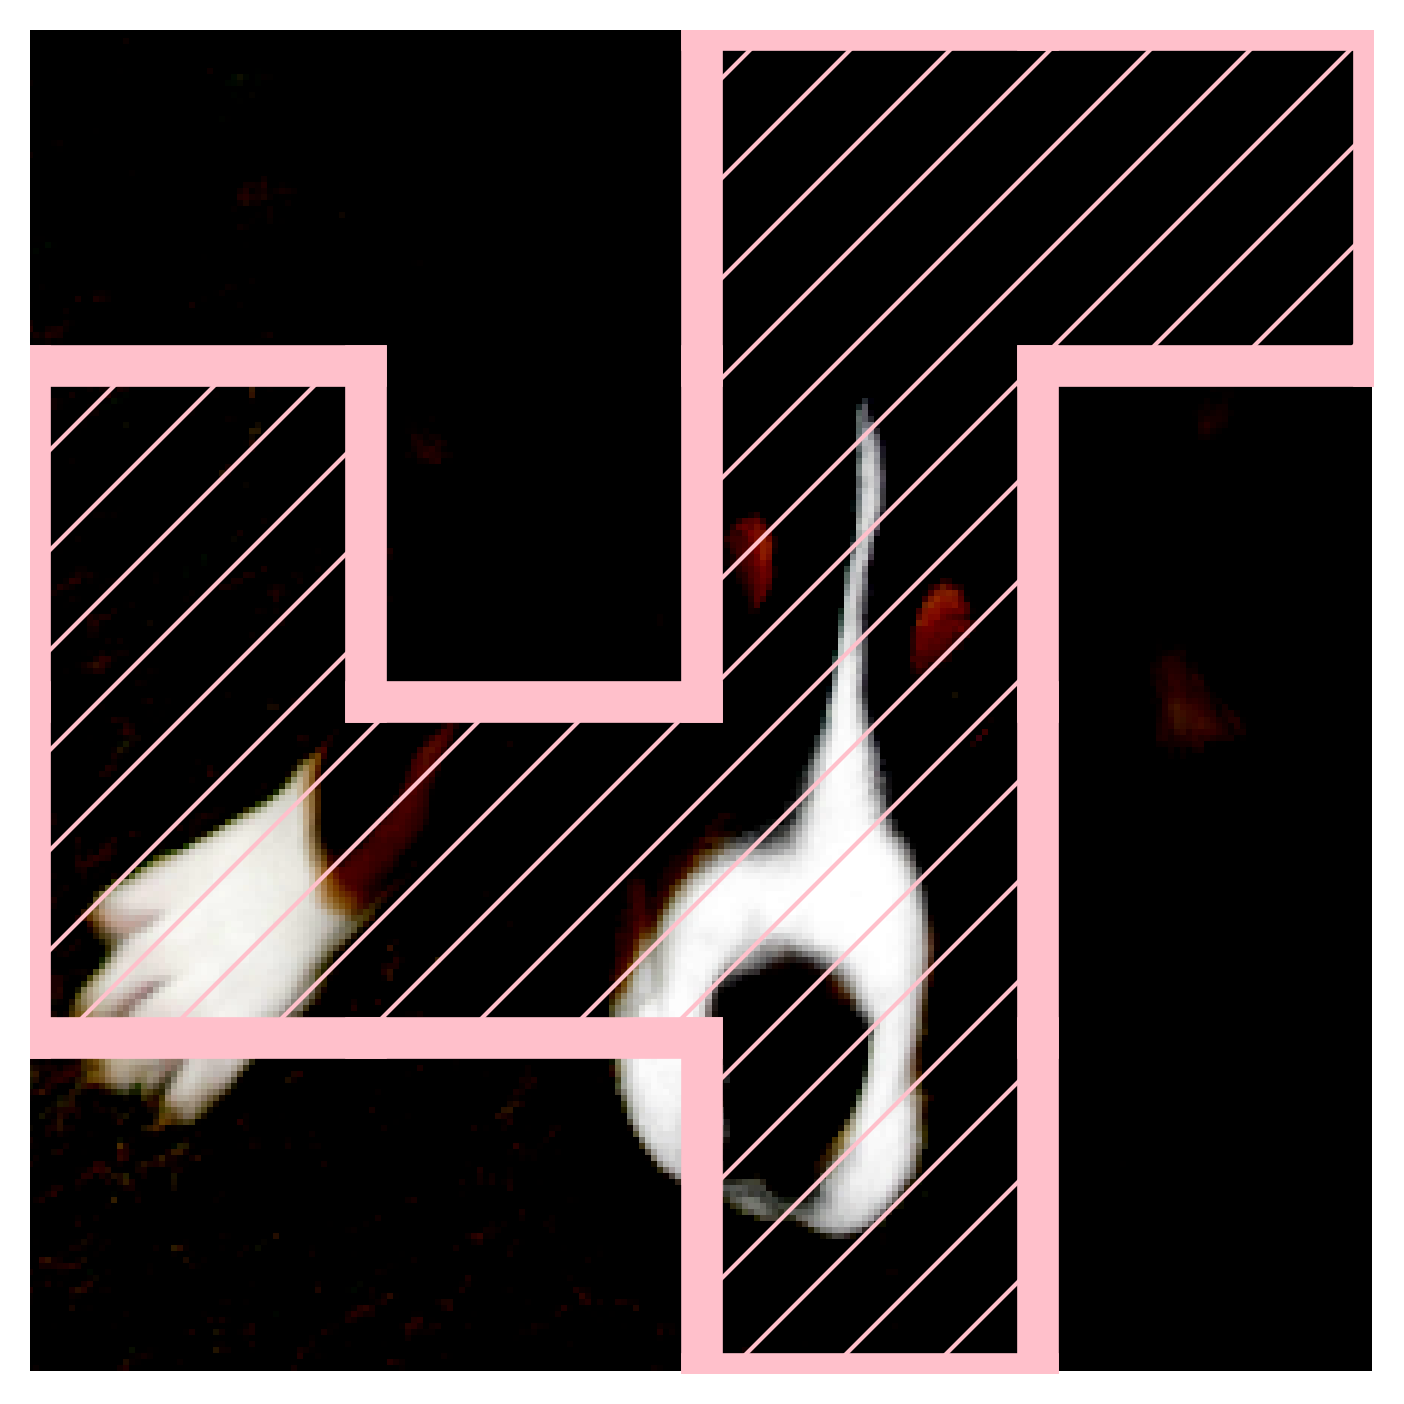

In [57]:
img = lime_image
imgi = 0
HIGH_DPI = 300  # Increase for better quality
SCALE_FACTOR = 2  # Adjust to make figure larger
mask = lime_expln_alpha.cpu().squeeze()
color = 'pink'
linewidth = 10
hatch = '/'
img_h, img_w = img.shape[1], img.shape[2]
patch_size = img_h / grid_size 

fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
ax.imshow(img.numpy().transpose(1, 2, 0))
ax.set_xlim(0, img_w)
ax.set_ylim(img_h, 0)
ax.set_position([0, 0, 1, 1])
ax.axis('off')
for i, j in zip(*np.where(mask == 1)):
    left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
    top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
    if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
    if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
for i, j in zip(*np.where(mask == 1)):
    ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
fig.canvas.draw()
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

# save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime.png'
# os.makedirs(os.path.dirname(save_path), exist_ok=True)
# plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)

In [40]:
idx = 238
i = 0
load_image_path = f'_dump/useful_images/{idx}/image_{idx}_lime_good_alpha_r1_{i}.png'
load_image = load_image_from_path(load_image_path)

In [41]:
ss_dict = torch.load(f'_dump/useful_images/{idx}/ss_dict.pt')
ss_dict.keys()

dict_keys(['soft_stability_rate', 'y', 'y_pertbs', 'alpha_pertbs', 'matches'])

In [42]:
ss_dict['alpha_pertbs'].shape

torch.Size([14979, 1, 4, 4])

In [57]:
good_alphas_r1[0].squeeze()

tensor([[0, 0, 1, 1],
        [1, 0, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 1, 1]])

(-0.5, 223.5, 223.5, -0.5)

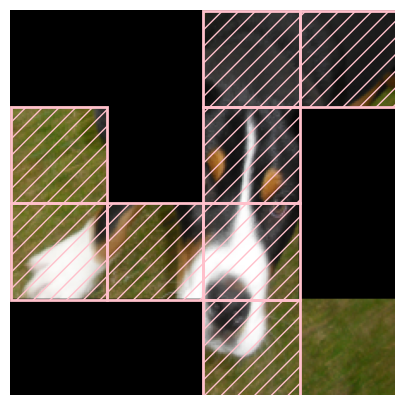

In [107]:
img = image_good_r1s[0]
mask = lime_expln_alpha.cpu().squeeze()

ig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(img.numpy().transpose(1,2,0))

for i, j in zip(*np.where(mask == 1)):
    ax.add_patch(patches.Rectangle(
        (j * patch_size, i * patch_size), patch_size, patch_size,
        linewidth=2, edgecolor='pink', facecolor='none', hatch='//'
      ))

ax.axis('off')

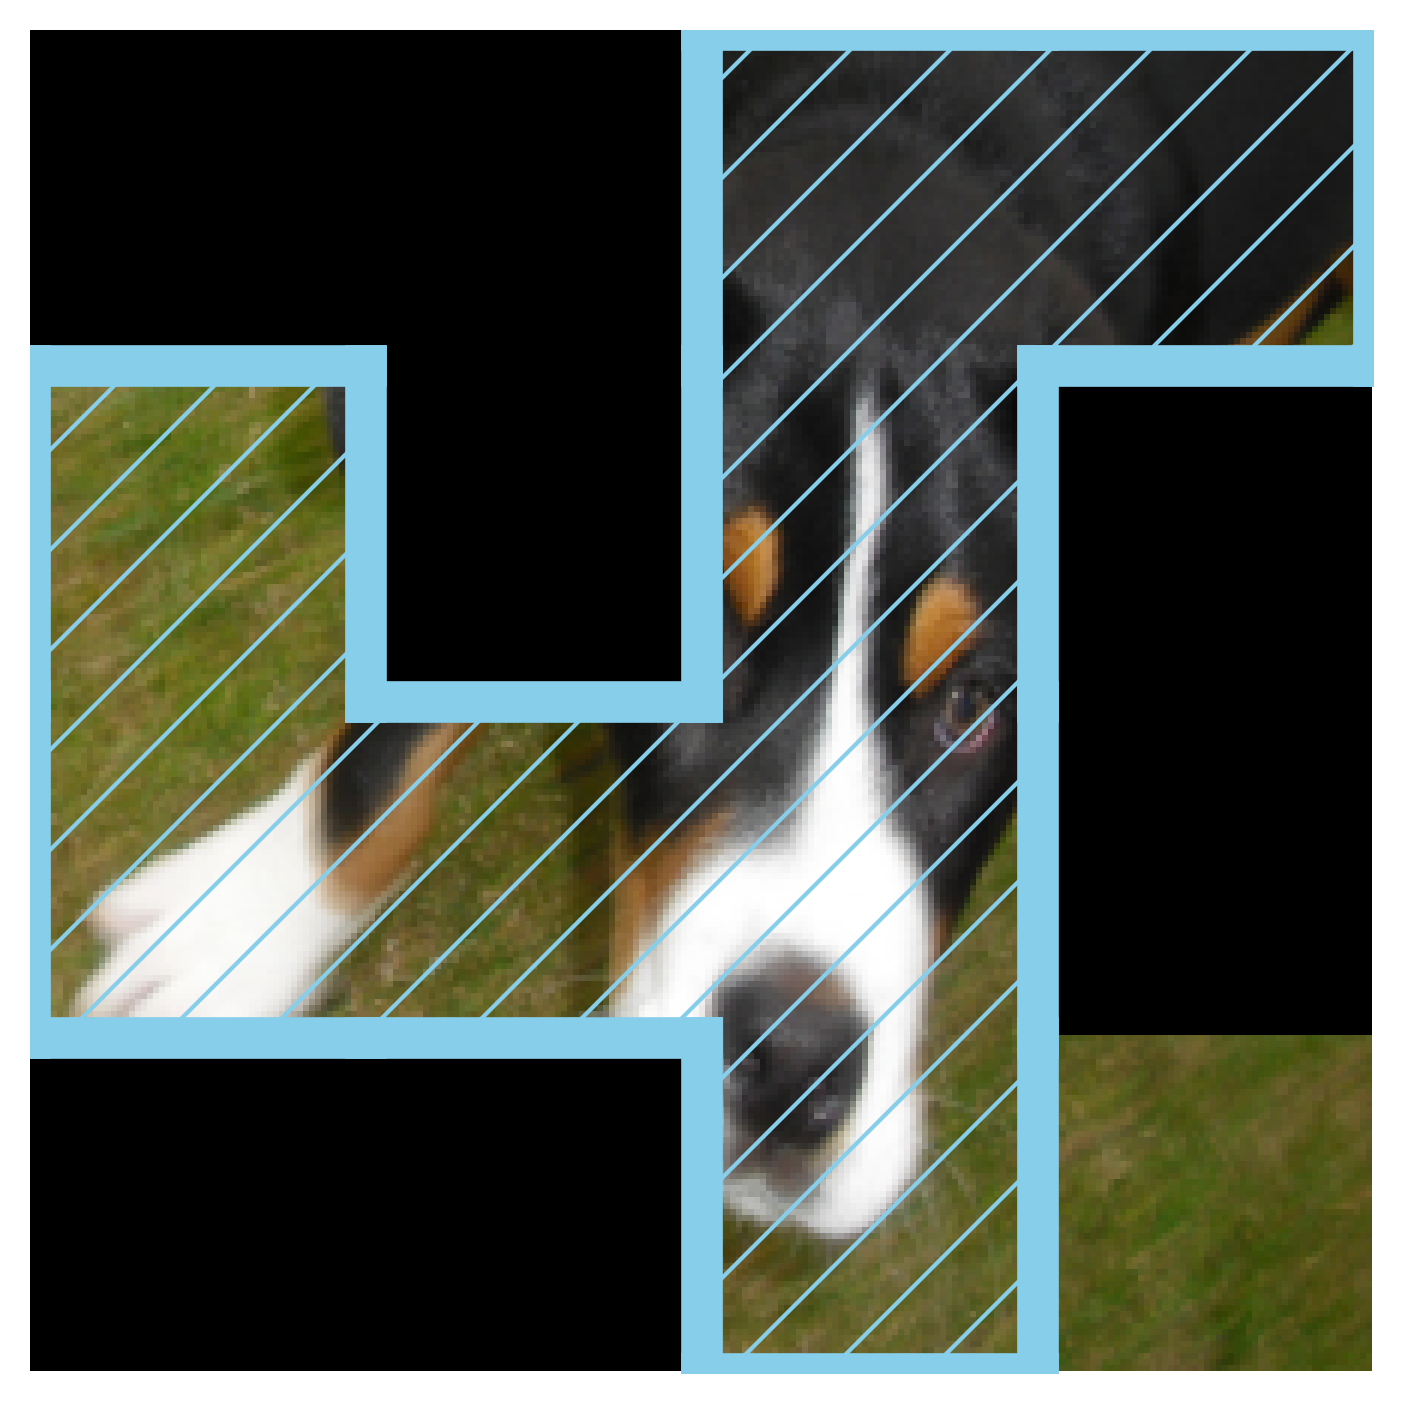

In [215]:
img = image_good_r1s[0]
imgi = 0
HIGH_DPI = 300  # Increase for better quality
SCALE_FACTOR = 2  # Adjust to make figure larger
mask = lime_expln_alpha.cpu().squeeze()
color = 'skyblue' #'#009E73' #'teal'
linewidth = 10
hatch = '/'
img_h, img_w = img.shape[1], img.shape[2]
patch_size = img_h / grid_size 

fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
ax.imshow(img.numpy().transpose(1, 2, 0))
ax.set_xlim(0, img_w)
ax.set_ylim(img_h, 0)
ax.set_position([0, 0, 1, 1])
ax.axis('off')
for i, j in zip(*np.where(mask == 1)):
    left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
    top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
    if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
    if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
for i, j in zip(*np.where(mask == 1)):
    ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
fig.canvas.draw()
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime_good_alpha_r1_{imgi}.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)

In [53]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

HIGH_DPI = 300  # Increase for better quality
SCALE_FACTOR = 2  # Adjust to make figure larger
mask = lime_expln_alpha.cpu().squeeze()
color = 'pink'
linewidth = 10
hatch = '/'
img_h, img_w = img.shape[1], img.shape[2]
patch_size = img_h / grid_size 

# for imgi, img in enumerate(image_good_r1s):
#     fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
#     ax.imshow(img.numpy().transpose(1, 2, 0))
#     ax.set_xlim(0, img_w)
#     ax.set_ylim(img_h, 0)
#     ax.set_position([0, 0, 1, 1])
#     ax.axis('off')
#     for i, j in zip(*np.where(mask == 1)):
#         left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
#         top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
#         if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
#         if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#     for i, j in zip(*np.where(mask == 1)):
#         ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
#     fig.canvas.draw()
#     bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime_good_alpha_r1_{imgi}.png'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)
#     plt.close()
    

# for imgi, img in enumerate(image_good_r2s):
#     fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
#     ax.imshow(img.numpy().transpose(1, 2, 0))
#     ax.set_xlim(0, img_w)
#     ax.set_ylim(img_h, 0)
#     ax.set_position([0, 0, 1, 1])
#     ax.axis('off')
#     for i, j in zip(*np.where(mask == 1)):
#         left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
#         top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
#         if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
#         if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#     for i, j in zip(*np.where(mask == 1)):
#         ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
#     fig.canvas.draw()
#     bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime_good_alpha_r2_{imgi}.png'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)
#     plt.close()

# for imgi, img in enumerate(image_good_r3s):
#     fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
#     ax.imshow(img.numpy().transpose(1, 2, 0))
#     ax.set_xlim(0, img_w)
#     ax.set_ylim(img_h, 0)
#     ax.set_position([0, 0, 1, 1])
#     ax.axis('off')
#     for i, j in zip(*np.where(mask == 1)):
#         left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
#         top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
#         if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
#         if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#     for i, j in zip(*np.where(mask == 1)):
#         ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
#     fig.canvas.draw()
#     bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime_good_alpha_r3_{imgi}.png'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)
#     plt.close()

# for imgi, img in enumerate(image_good_r4s):
#     fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
#     ax.imshow(img.numpy().transpose(1, 2, 0))
#     ax.set_xlim(0, img_w)
#     ax.set_ylim(img_h, 0)
#     ax.set_position([0, 0, 1, 1])
#     ax.axis('off')
#     for i, j in zip(*np.where(mask == 1)):
#         left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
#         top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
#         if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
#         if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#     for i, j in zip(*np.where(mask == 1)):
#         ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
#     fig.canvas.draw()
#     bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime_good_alpha_r4_{imgi}.png'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)
#     plt.close()

# for imgi, img in enumerate(image_good_r5s):
#     fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
#     ax.imshow(img.numpy().transpose(1, 2, 0))
#     ax.set_xlim(0, img_w)
#     ax.set_ylim(img_h, 0)
#     ax.set_position([0, 0, 1, 1])
#     ax.axis('off')
#     for i, j in zip(*np.where(mask == 1)):
#         left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
#         top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
#         if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
#         if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#     for i, j in zip(*np.where(mask == 1)):
#         ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
#     fig.canvas.draw()
#     bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime_good_alpha_r5_{imgi}.png'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)
#     plt.close()

for imgi, img in enumerate(image_good_r6s):
    fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
    ax.imshow(img.numpy().transpose(1, 2, 0))
    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_position([0, 0, 1, 1])
    ax.axis('off')
    for i, j in zip(*np.where(mask == 1)):
        left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
        top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
        if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
        if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
        if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
        if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    for i, j in zip(*np.where(mask == 1)):
        ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
    fig.canvas.draw()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime_good_alpha_r6_{imgi}.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)
    plt.close()


for imgi, img in enumerate(image_good_r7s):
    fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
    ax.imshow(img.numpy().transpose(1, 2, 0))
    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_position([0, 0, 1, 1])
    ax.axis('off')
    for i, j in zip(*np.where(mask == 1)):
        left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
        top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
        if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
        if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
        if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
        if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    for i, j in zip(*np.where(mask == 1)):
        ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
    fig.canvas.draw()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime_good_alpha_r7_{imgi}.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)
    plt.close()

In [54]:
HIGH_DPI = 300  # Increase for better quality
SCALE_FACTOR = 2  # Adjust to make figure larger
mask = lime_expln_alpha.cpu().squeeze()
color = 'pink'
linewidth = 10
hatch = '/'
img_h, img_w = img.shape[1], img.shape[2]
patch_size = img_h / grid_size 

# for imgi, img in enumerate(image_bad_r3s):
#     fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
#     ax.imshow(img.numpy().transpose(1, 2, 0))
#     ax.set_xlim(0, img_w)
#     ax.set_ylim(img_h, 0)
#     ax.set_position([0, 0, 1, 1])
#     ax.axis('off')
#     for i, j in zip(*np.where(mask == 1)):
#         left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
#         top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
#         if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
#         if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#     for i, j in zip(*np.where(mask == 1)):
#         ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
#     fig.canvas.draw()
#     bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime_bad_alpha_r3_{imgi}.png'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)
#     plt.close()

# for imgi, img in enumerate(image_bad_r4s):
#     fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
#     ax.imshow(img.numpy().transpose(1, 2, 0))
#     ax.set_xlim(0, img_w)
#     ax.set_ylim(img_h, 0)
#     ax.set_position([0, 0, 1, 1])
#     ax.axis('off')
#     for i, j in zip(*np.where(mask == 1)):
#         left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
#         top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
#         if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
#         if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#     for i, j in zip(*np.where(mask == 1)):
#         ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
#     fig.canvas.draw()
#     bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime_bad_alpha_r4_{imgi}.png'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)
#     plt.close()

# for imgi, img in enumerate(image_bad_r5s):
#     fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
#     ax.imshow(img.numpy().transpose(1, 2, 0))
#     ax.set_xlim(0, img_w)
#     ax.set_ylim(img_h, 0)
#     ax.set_position([0, 0, 1, 1])
#     ax.axis('off')
#     for i, j in zip(*np.where(mask == 1)):
#         left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
#         top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
#         if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
#         if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#         if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
#     for i, j in zip(*np.where(mask == 1)):
#         ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
#     fig.canvas.draw()
#     bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime_bad_alpha_r5_{imgi}.png'
#     os.makedirs(os.path.dirname(save_path), exist_ok=True)
#     plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)
#     plt.close()


for imgi, img in enumerate(image_bad_r6s):
    fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
    ax.imshow(img.numpy().transpose(1, 2, 0))
    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_position([0, 0, 1, 1])
    ax.axis('off')
    for i, j in zip(*np.where(mask == 1)):
        left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
        top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
        if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
        if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
        if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
        if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    for i, j in zip(*np.where(mask == 1)):
        ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
    fig.canvas.draw()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime_bad_alpha_r6_{imgi}.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)
    plt.close()
    
for imgi, img in enumerate(image_bad_r7s):
    fig, ax = plt.subplots(figsize=(SCALE_FACTOR * img_w / 100, SCALE_FACTOR * img_h / 100), dpi=HIGH_DPI)
    ax.imshow(img.numpy().transpose(1, 2, 0))
    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_position([0, 0, 1, 1])
    ax.axis('off')
    for i, j in zip(*np.where(mask == 1)):
        left, right = j == 0 or mask[i, j - 1] == 0, j == mask.shape[1] - 1 or mask[i, j + 1] == 0
        top, bottom = i == 0 or mask[i - 1, j] == 0, i == mask.shape[0] - 1 or mask[i + 1, j] == 0
        if top: ax.plot([j * patch_size, (j + 1) * patch_size], [i * patch_size, i * patch_size], color=color, linewidth=linewidth)
        if bottom: ax.plot([j * patch_size, (j + 1) * patch_size], [(i + 1) * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
        if left: ax.plot([j * patch_size, j * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
        if right: ax.plot([(j + 1) * patch_size, (j + 1) * patch_size], [i * patch_size, (i + 1) * patch_size], color=color, linewidth=linewidth)
    for i, j in zip(*np.where(mask == 1)):
        ax.add_patch(patches.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=0, edgecolor=color, facecolor='none', hatch=hatch))
    fig.canvas.draw()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    save_path = f'_dump/useful_images/{idx}/masked_image_{idx}_lime_bad_alpha_r7_{imgi}.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=HIGH_DPI, bbox_inches=bbox, pad_inches=0, transparent=True)
    plt.close()